In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
import matplotlib
import sys
import pandas as pd

sys.path.append('../')
from carpet_reconstruction import GetCarpetSignal, VEM, get_rho, NKG, num_sort, get_xy_fits, get_xy, get_annealing_xy, get_xy_lm

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import peak_local_max
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.special import gamma

In [2]:
# matplotlib.use('pdf') #Чтобы не убить оперативку
plt.rcParams['figure.dpi'] = 400

In [3]:
photon_data = pd.read_csv('../photon_28k_roof.csv')
photon_data

,"E, TeV","Theta, deg","Phi, deg","x, m","y, m","Z_first, cm",Ne,N_mu total,"remote one trigger time, ns","remote two trigger time, ns",...,390,391,392,393,394,395,396,397,398,399
0,10.0,26.29070,-170.7457,-4.875987,-0.794481,5411720.0,1046.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.0,24.72480,179.5575,-4.604594,0.035562,3056420.0,6602.0,0.0,0.000000,106088.898438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001502,0.000000,0.000000
2,10.0,33.06550,165.0478,-6.289910,1.679753,4800420.0,566.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,10.0,2.39251,-44.8180,0.296377,-0.294500,2372820.0,5437.0,0.0,0.000000,0.000000,...,0.190691,0.000000,0.006006,0.000000,0.001502,0.010511,0.000000,0.000000,0.099099,0.000000
4,10.0,30.12960,21.6857,5.392943,2.144554,3009020.0,2552.0,0.0,109597.351562,0.000000,...,0.007508,0.000000,0.000000,0.003003,0.003003,0.028529,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,150.0,18.45820,169.4438,-3.281352,0.611492,3289190.0,309357.0,0.0,109712.421875,109770.593750,...,5.510511,5.207207,14.037538,0.812312,6.297297,1.066066,9.016517,5.965465,3.127628,0.301802
28196,150.0,12.29430,24.6011,1.981490,0.907243,2367200.0,247321.0,0.0,75166.664062,75039.781250,...,7.561562,11.073574,4.653153,2.951952,10.118619,9.728228,3.903904,7.669670,4.193694,4.722222
28197,150.0,23.77690,-93.3430,-0.256911,-4.398213,2389510.0,146115.0,0.0,80981.531250,80999.796875,...,1.250751,2.837838,7.085586,5.055556,5.840841,3.108108,1.843844,4.876877,3.447447,1.118619
28198,150.0,16.85650,-166.3730,-2.944649,-0.713854,3629780.0,289233.0,0.0,120647.554688,120672.023438,...,12.091592,12.480480,2.094595,1.888889,2.424925,7.192192,4.921922,1.442943,4.039039,4.881381


In [4]:
cover_signals = photon_data.iloc[:,12:412].to_numpy()

# Корректность определения положения оси

In [5]:
cover_coords = photon_data.iloc[:,3:5].to_numpy()
cover_coords

array([[-4.87598705, -0.79448057],
       [-4.60459393,  0.03556236],
       [-6.28991016,  1.67975339],
       ...,
       [-0.25691133, -4.39821334],
       [-2.94464862, -0.71385449],
       [-4.58421159,  2.67465564]])

In [6]:
# pdf = PdfPages("28200_Showers_coord_real_vs_rec.pdf")

# for i, cover_signal in enumerate(cover_signals):

#     signal = cover_signal.reshape((20, 20))
#     sig = VEM(signal)

#     plt.imshow(sig, cmap='turbo')
    
#     row0, col0 = get_xy_fits(sig)
#     plt.plot(col0, row0, 'mo')

#     col_real = (cover_coords[i, 0] + 6.65)/0.7
#     row_real = (6.65 - cover_coords[i, 1])/0.7
#     plt.plot(col_real, row_real, 'go')

#     pdf.savefig()
#     plt.close('all')

# pdf.close()

In [17]:
errors = []
inout_array = np.zeros((2,2), dtype=np.int32)

for i, cover_signal in enumerate(cover_signals):
    
    signal = cover_signal.reshape((20, 20))
    sig = VEM(signal)
    
    N_triggered = np.count_nonzero(sig)
    if (N_triggered >= 50):

        #x0, y0 = get_xy(sig)
        
        # row0, col0 = np.unravel_index(sig.argmax(), sig.shape)
        # x0 : float = 0.7*col0 - 6.65
        # y0 : float = 6.65 - 0.7*row0
    
        x0, y0 = get_xy_lm(sig)
    
        x_real, y_real = cover_coords[i]
        
        coord_err = np.linalg.norm((x_real-x0, y_real-y0))
    
        if (coord_err > 50):
            print(i , coord_err, [x0, y0], [x_real, y_real])
    
        if (((np.abs(x_real) < 6.3) and (np.abs(y_real) < 6.3)) and ((np.abs(x0) < 6.3) and (np.abs(y0) < 6.3))):
            inout_array[0, 0] += 1
        elif ( (not ((np.abs(x_real) < 6.3) and (np.abs(y_real) < 6.3))) and ((np.abs(x0) < 6.3) and (np.abs(y0) < 6.3))):
            inout_array[0, 1] += 1
        elif ( ((np.abs(x_real) < 6.3) and (np.abs(y_real) < 6.3)) and (not ((np.abs(x0) < 6.3) and (np.abs(y0) < 6.3)))):
            inout_array[1, 0] += 1
        elif ( (not ((np.abs(x_real) < 6.3) and (np.abs(y_real) < 6.3))) and (not ((np.abs(x0) < 6.3) and (np.abs(y0) < 6.3)))):
            inout_array[1, 1] += 1
    
        errors.append(coord_err)

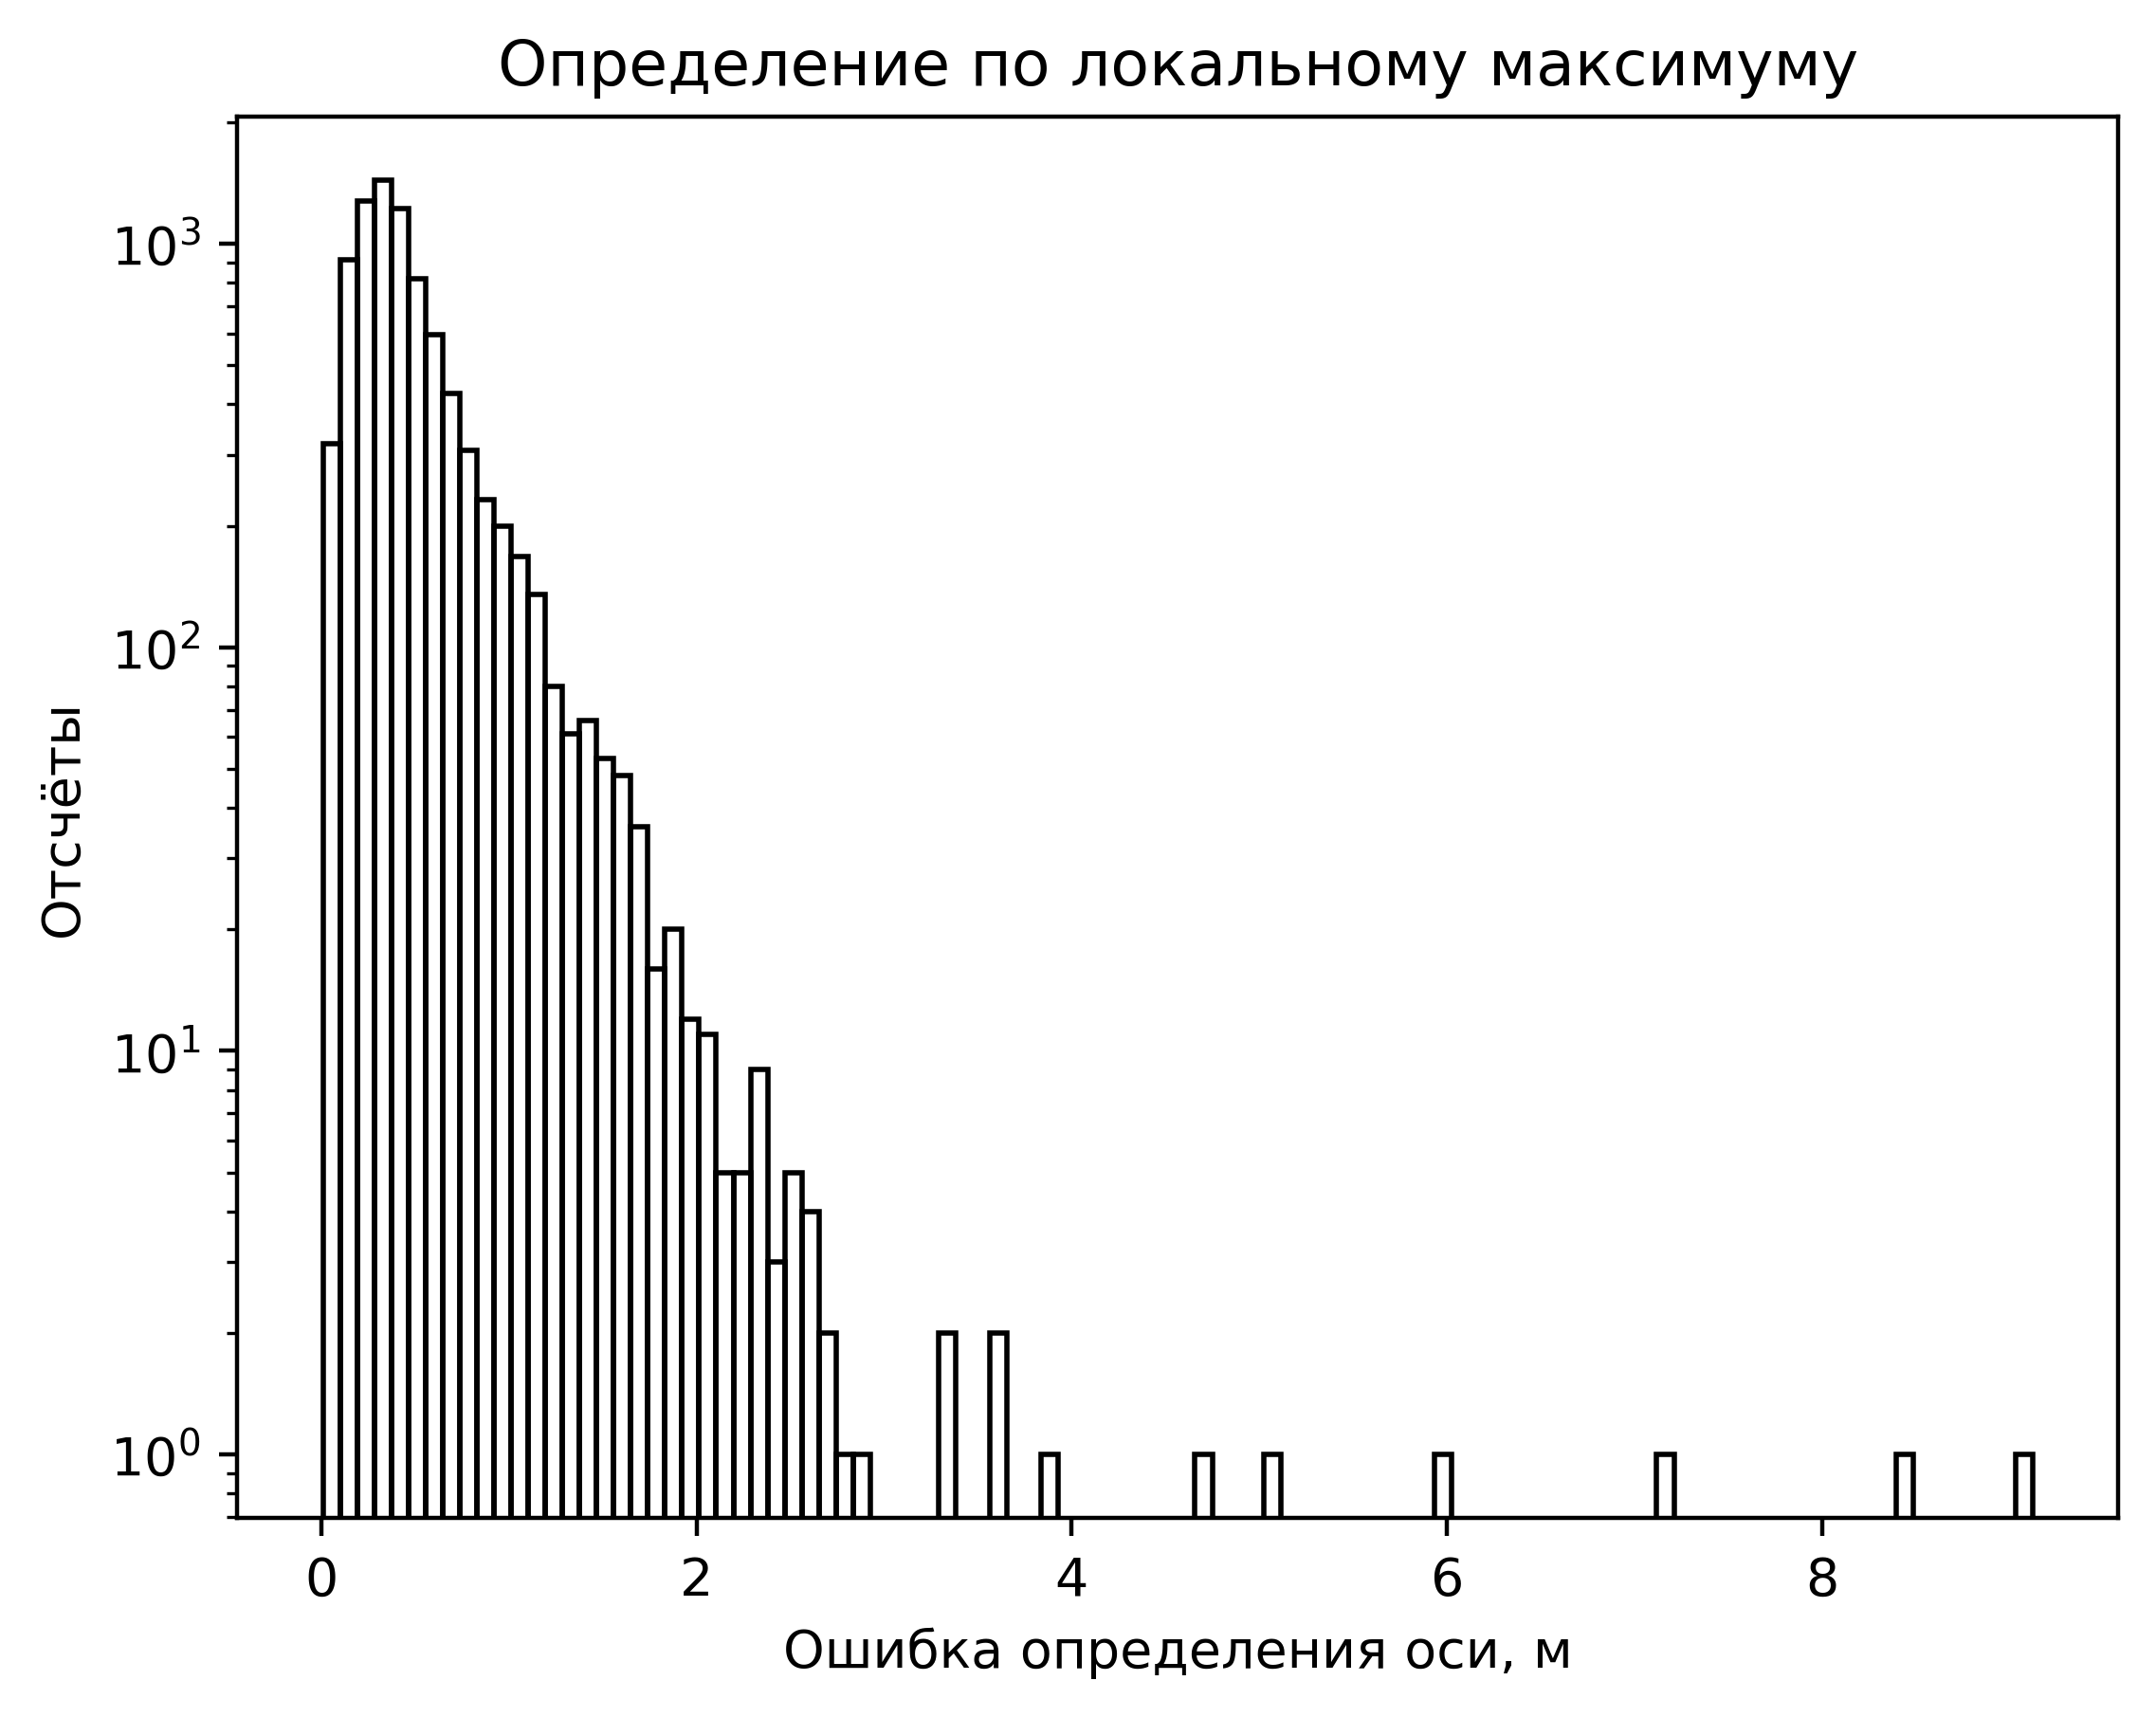

In [18]:
plt.hist(errors, bins=100, fill=False)

plt.ylabel('Отсчёты')
plt.xlabel('Ошибка определения оси, м')

plt.yscale('log')

#plt.title('Определение по МНК')
# plt.title('Определение по максимальному детектору')
plt.title('Определение по локальному максимуму')

# plt.savefig('xy_error.png')
# plt.savefig('xy_maxdet_error.png')
plt.savefig('xy_lm_error.png')

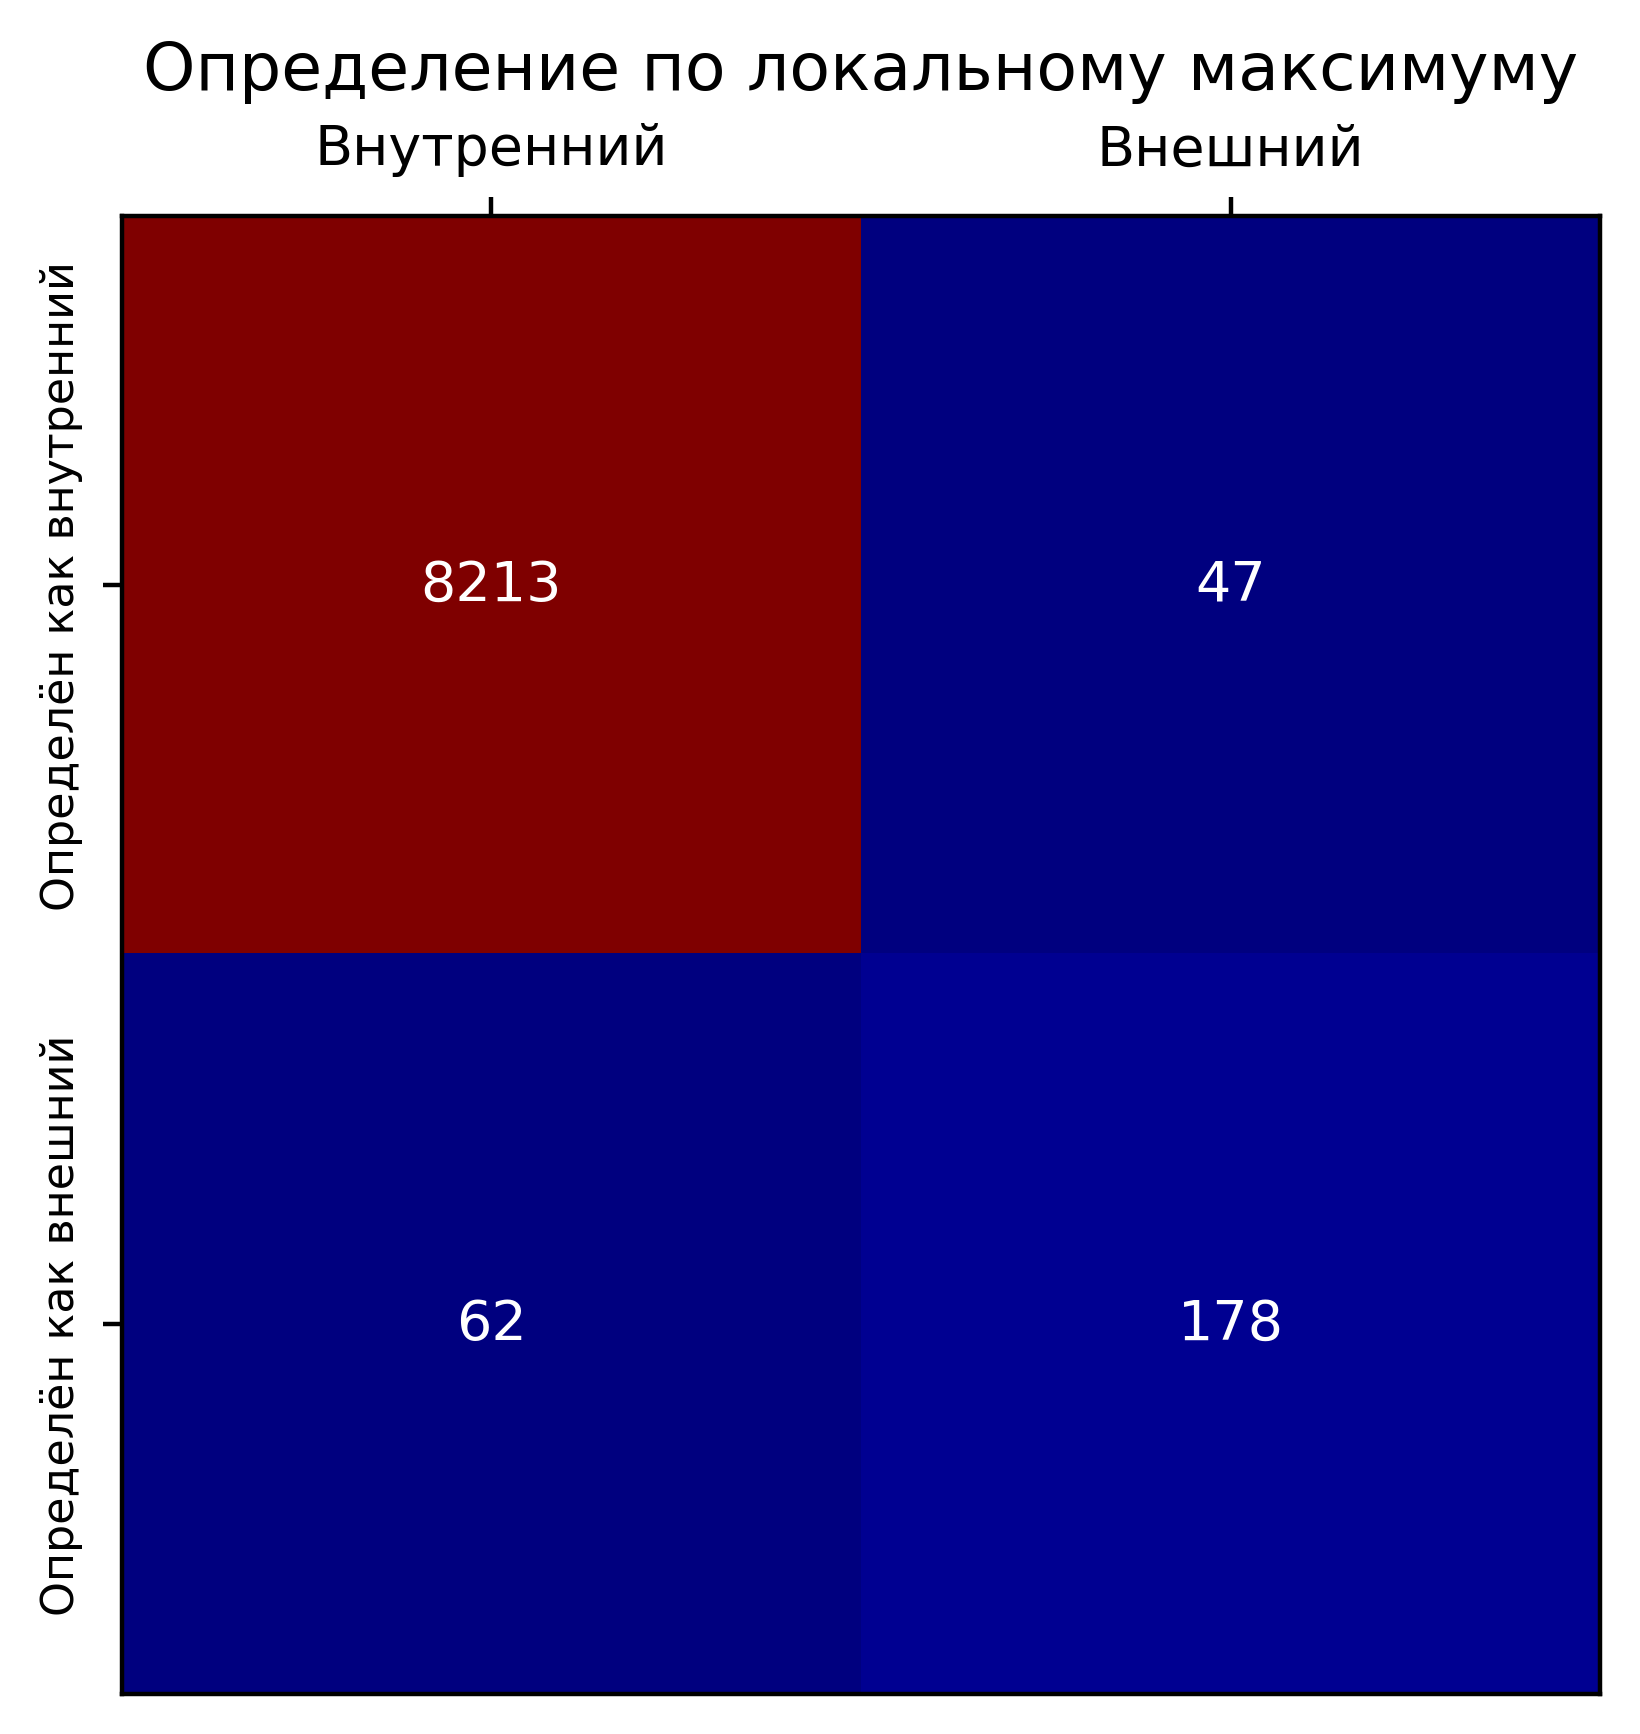

In [46]:
plt.imshow(inout_array, cmap='jet')

column_labels = ['Внутренний', 'Внешний']
row_labels = ['Определён как внутренний', 'Определён как внешний']

plt.xticks(np.arange(inout_array.shape[1]), minor=False)
plt.yticks(np.arange(inout_array.shape[0]), minor=False)

for i in range(inout_array.shape[0]):
    for j in range(inout_array.shape[1]):
        text = plt.text(j, i, inout_array[i, j],
                       ha="center", va="center", color="w")

ax = plt.gca()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False, rotation='vertical', va='center',fontsize=8)

#plt.title('Определение по МНК')
# plt.title('Определение по максимальному детектору')
plt.title('Определение по локальному максимуму')

# plt.savefig('xy_error_matrix.png')
# plt.savefig('xy_maxdet_error_matrix.png')
plt.savefig('xy_lm_error_matrix.png')

In [ ]:
cover_times = photon_data.iloc[:,8:12].to_numpy()

In [ ]:
time_array = cover_times[-1]
theta, phi = get_PFAWTC_theta(time_array, x0, y0)